# Libraries

In [1]:
pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.6/817.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 

In [2]:

pip install pmdarima

In [3]:

pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 10.5 MB/s eta 0:00:00


In [ ]:
#pip install darts
#pip install pmdarima
#pip install arch

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Stationarity and mixing
import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import plot_acf, plot_pacf, plot_hist
from darts.utils.statistics import stationarity_test_adf, stationarity_test_kpss # Tests to check stationarity of the series
from darts.utils.missing_values import fill_missing_values

# ARIMA-GARCH models
from scipy.stats import chi2
from arch import arch_model
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox # White-noise test
from statsmodels.stats.diagnostic import het_arch # test to check for absence of ARCH effects in residuals
import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sm

import yfinance as yf

# Data

Using the Yahoo-finance API, we were able to retrieve 30 days worth of BTC-USD (bitcoin, in \$) historical prices at 1-min intervals. This time series, which we will denote $(X_t)$, is univariate: on such a tiny interval, Yahoo-finance does not provide any information besides the average price $X_t$ at minute $t$ (namely, the 'Open', 'Close', 'High' and 'Low' prices for a specific $t$ are equal).

In [ ]:
# btc = yf.Ticker("btc-usd")

# start_date = int(time.time())-29*86400 # 2023-11-02
# five_days = 5 * 86400 # in seconds

# historical_data = pd.DataFrame()
# for i in range(6): # Only one month of data is available.
#   btc_historical = btc.history(start=start_date, end=start_date+five_days, interval="1m")
#   start_date = start_date + five_days

#   historical_data = pd.concat([historical_data, btc_historical])

# historical_data = historical_data.reset_index() # To create the column "Datetime"
# historical_data["Datetime"] = pd.to_datetime(historical_data.Datetime).dt.tz_localize(None) # We convert the "Datetime" to a good format

# historical_data.Open.plot(title="Bitcoin price: 06/11/2023 - 06/12/2023",
#                           xlabel="Time in minutes",
#                           ylabel="1 Bitcoin in USD")
# plt.show()

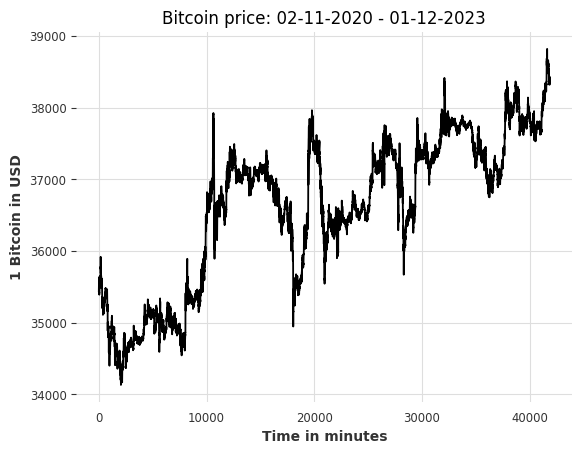

In [5]:
historical_data = pd.read_csv('Bitcoin_20231102_to_20231201_excluded.csv')
historical_data['Datetime'] = pd.to_datetime(historical_data.Datetime).dt.tz_localize(None) # We convert the "Datetime" to a good format

historical_data.Open.plot(title="Bitcoin price: 02-11-2020 - 01-12-2023",
                          xlabel="Time in minutes",
                          ylabel="1 Bitcoin in USD")
plt.show()

# Traditional Affine Causal Models

The traditional framework often used to carry out a Time Series project consists in assuming the series $(X_t)_{t\in\mathbb{Z}}$ of interest can be seen as an affine causal process, following the dynamic:

\begin{equation}
    X_t = M_{\theta}(X_{t-1}, X_{t-2},\dots)\cdot \xi_t + F_{\theta}(X_{t-1}, X_{t-2},\dots)
\end{equation}

where $(\xi_t)_{t\in \mathbb{Z}}$ is a white noise (i.e $\mathbb{E}[\xi_t] = 0$, $\mathbb{E}[\xi_t^2] = \sigma^2>0$ and $\mathbb{E}[\xi_t\xi_{\tau}]=0$ for $\tau \ne t$) with $\sigma^2 = 1$, and $F_{\theta}, M_{\theta}:\mathbb{R}^{\infty} \to \mathbb{R}$ are two functions. The whole goal of the project is then to determine the vector of parameters $\theta^*$ that allows the best forecasts for $X_{t}$, knowing its past $\mathcal{F}_{t-1}$.

Inside the class of affine causal models, Auto Regressive Integrated Moving Average (ARIMA) or Generalized Auto Regressive Conditional Heteroscedasticity (GARCH) models are well-known and considered as proven solutions in the study of Time Series. In light of this, we wanted to give them a try.

## 3.1 Stationarity and mixing properties

The standard hypothesis over a Time Series one can make are stationarity and mixing property.

A stochastic process $(X_t)$ is said to be (second order) stationary whenever $t\mapsto \mathbb{E}[X_t]$ and $t,h\mapsto \mathbb{C}\mathrm{ov}(X_{t}, X_{t+h})$ are constant with respect to $t$ (and $\mathbb{E}[X_t^2] < +\infty$ incidentally). This property can be checked through two widely used statistical tests: the Augmented Dickey-Fuller (ADF) test, and the  Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

On the other hand, $(X_t)$ is mixing if its values at widely separated times are asymptotically independent, which translates to saying that:
\begin{equation}
    \mathbb{P}(X_{t+h}\in A, X_t \in B) \underset{h \to +\infty}{\to} \mathbb{P}(X_{t+h} \in A)\mathbb{P}(X_t \in B) \quad \forall A,B\in \mathcal{A}
\end{equation}
The autocorrelation and partial autocorrelation functions graphs are good leading indicators of mixing. Mixing implies ergodicity, which is often a valuable property.

### 3.1.1 Stationarity

In [10]:
X = TimeSeries.from_dataframe(historical_data, "Datetime", "Open", fill_missing_dates=True, freq='min')
X = fill_missing_values(X)# minutes "23:59" are missing.

In [8]:
print("--- ADF test ---")
print(stationarity_test_adf(X))

print("\n--- KPSS test ---")
print(stationarity_test_kpss(X))

--- ADF test ---
(-1.602155207882936, 0.4825107506546924, 40, 42563, {'1%': -3.4305036474032358, '5%': -2.8616079087352437, '10%': -2.5668061456193474}, 365883.2790321357)

--- KPSS test ---
(24.723994306792378, 0.01, 120, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/usr/local/lib/python3.10/dist-packages/darts/utils/statistics.py:459: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


The ADF test assumes absence of Unit Root as the null hypothesis while KPSS test assumes the opposite. After conducting both of these tests on our raw data $(X_t)$, the above results strongly reject the absence of Unit Root in the raw series $(X_t)$.

Instead in finance, log-returns are often studied for their interesting additive property. Here, the log-returns series $(Y_t)$ is defined as:
\begin{equation}
    Y_t = \log\left(\frac{X_t}{X_{t-1}}\right)\quad \forall t \in \mathbb{Z}
\end{equation}

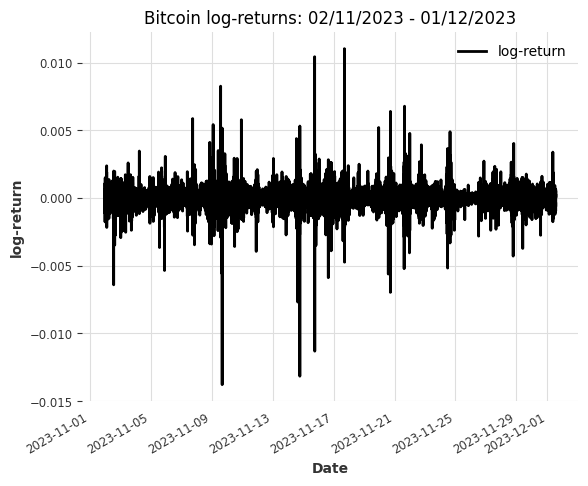

In [ ]:
Y = X.map(np.log).diff() # Y_t = log(X_t/X_(t-1))

Y.plot(label="log-return")
plt.title("Bitcoin log-returns: 02/11/2023 - 01/12/2023")
plt.xlabel("Date")
plt.ylabel("log-return")
plt.show()

In [12]:
print("--- ADF test ---")
print(stationarity_test_adf(Y))

print("\n--- KPSS test ---")
print(stationarity_test_kpss(Y))

--- ADF test ---
(-33.383709107525426, 0.0, 39, 42563, {'1%': -3.4305036474032358, '5%': -2.8616079087352437, '10%': -2.5668061456193474}, -528229.4965869797)

--- KPSS test ---
(0.025859343045443017, 0.1, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/usr/local/lib/python3.10/dist-packages/darts/utils/statistics.py:459: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


This time, the above tests respectively returned the statistics ($\simeq -33., \simeq 0.00$) and ($\simeq 0.02, > 0.10$) which allow us to confidently consider the series $(Y_t)$ stationary.

### Mixing

If $(Y_t)$ is mixing, we expect that for $h$ sufficiently large, $Y_{t+h}$ is approximately independent from $Y_t$, which translates to

\begin{equation}
    \mathbb{E}[h(Y_{t+h})h(Y_t)] \approx \mathbb{E}[h(Y_{t+h})] \mathbb{E}[h(Y_t)]
\end{equation}

for all $h:\mathbb{R} \to \mathbb{R}$ measurable, bounded or positive.

In particular, we can check whether $\mathbb{C}\mathrm{ov}(Y_{t+h}, Y_t) = \mathbb{E}[Y_{t+h}Y_t] - \mathbb{E}[Y_{t+h}]\mathbb{E}[Y_t] \approx 0$ and $\mathbb{C}\mathrm{ov}(|Y_{t+h}|, |Y_t|) \approx 0$ as $h$ grows.

Assuming $(Y_t)$ mixing, the series is also ergodic, so $(|Y_t|)$ is also ergodic. Under this hypothesis, we can check autocorrelation graphs of $(Y_t)$ and $(|Y_t|)$.

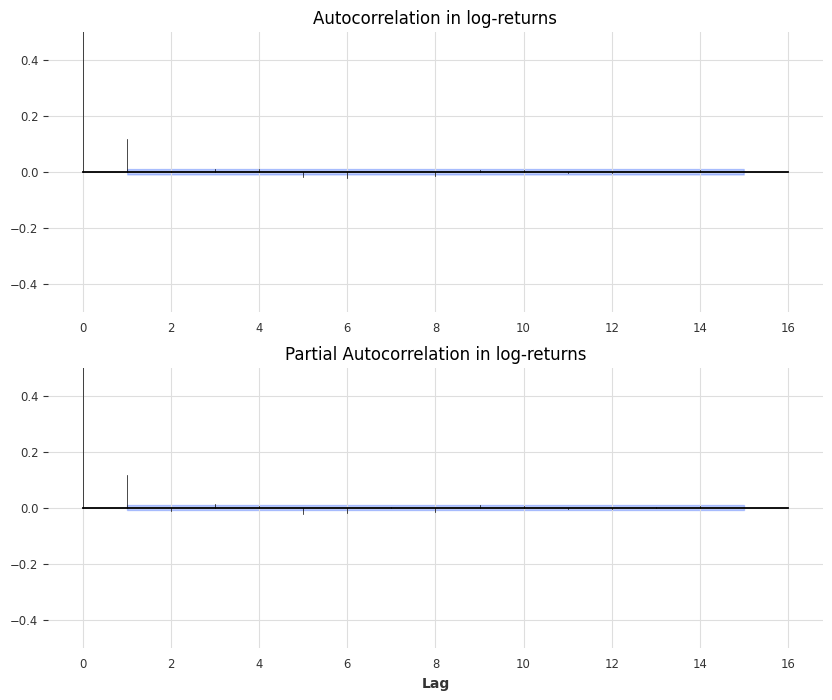

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(Y, axis=ax1, alpha=0.05, max_lag=15)
ax1.set_ylim(-0.5, .5)
ax1.set_title("Autocorrelation in log-returns")
plot_pacf(Y, axis=ax2, alpha=0.05, max_lag=15)
ax2.set_ylim(-0.5, .5)
ax2.set_xlabel("Lag")
ax2.set_title("Partial Autocorrelation in log-returns")

plt.show()

In [14]:
Y_abs = Y.map(np.abs)
print("--- ADF test ---")
print(stationarity_test_adf(Y_abs))

print("\n--- KPSS test ---")
print(stationarity_test_kpss(Y_abs))

--- ADF test ---
(-12.902560110506494, 4.218019508771371e-24, 54, 42548, {'1%': -3.4305037015738225, '5%': -2.8616079326768182, '10%': -2.56680615836278}, -555992.6443747847)

--- KPSS test ---
(0.7896272880024808, 0.01, 105, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/usr/local/lib/python3.10/dist-packages/darts/utils/statistics.py:459: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


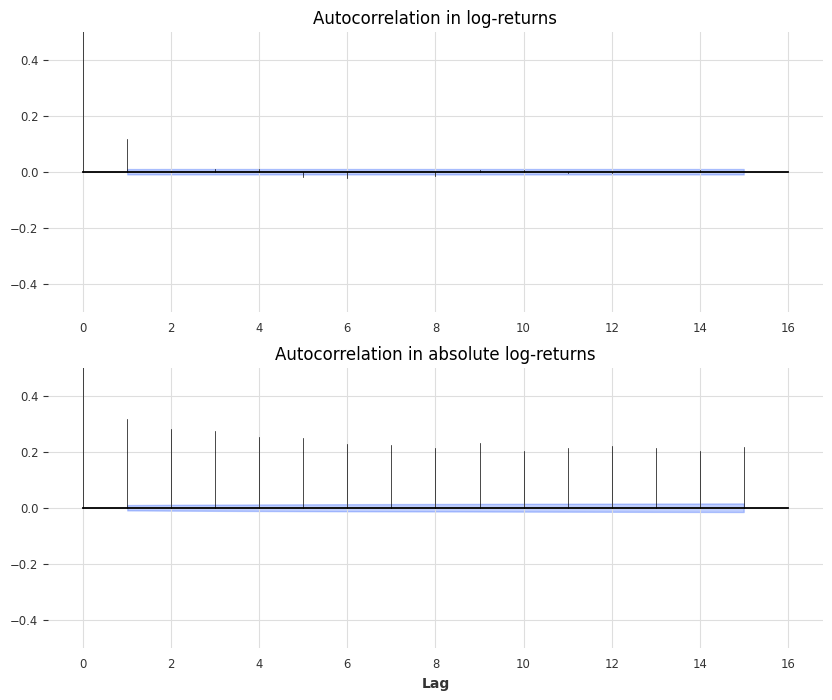

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(Y, axis=ax1, alpha=0.05, max_lag=15)
ax1.set_ylim(-0.5, .5)
ax1.set_title("Autocorrelation in log-returns")
plot_acf(Y_abs, axis=ax2, alpha=0.05, max_lag=15)
ax2.set_ylim(-0.5, .5)
ax2.set_xlabel("Lag")
ax2.set_title("Autocorrelation in absolute log-returns")

plt.show()

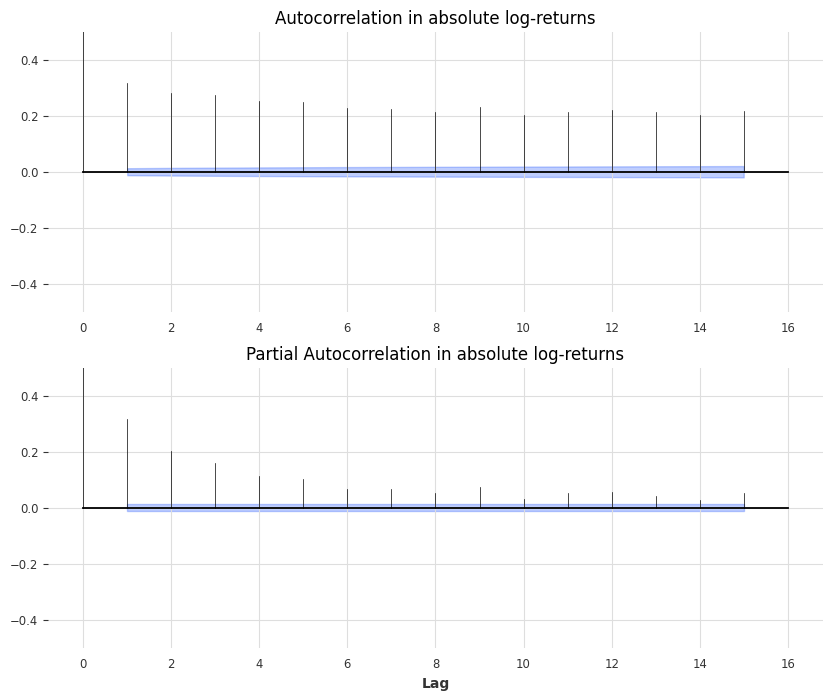

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(Y_abs, axis=ax1, alpha=0.01, max_lag=15)
ax1.set_ylim(-0.5, .5)
ax1.set_title("Autocorrelation in absolute log-returns")
plot_pacf(Y_abs, axis=ax2, alpha=0.01, max_lag=15)
ax2.set_ylim(-0.5, .5)
ax2.set_xlabel("Lag")
ax2.set_title("Partial Autocorrelation in absolute log-returns")

plt.show()

The graphs above represent autocorrelation and partial autocorrelation of $(Y_t)$ and $(|Y_t|)$. We see that although $(Y_t)$ presents autocorrelation with exponential decay, this is not the case of $(|Y_t|)$, hence the series $(Y_t)$ is not mixing.

## 3.2 ARIMA-GARCH models

An ARMA($p,q$)-GARCH($p',q'$) process is, for $p,q\geq 0$ and $p',q'\geq 0$, a stationary series $(X_t)$ such that for all $t\in \mathbb{Z}$:
\begin{equation}
    X_t = a_0 + a_1X_{t-1} + \dots + a_pX_{t-p} + \xi_t + b_1\xi_{t-1} + \dots + b_q\xi_{t-q}
\end{equation}
with
\begin{equation}
    \xi_t = \varepsilon_t \sigma_t \quad \text{and}\quad \sigma_t^2 = \omega_0 + c_1\xi_{t-1}^2 +\dots + c_{p'}\xi_{t-p'}^2 + d_1\sigma_{t-1}^2 +\dots + d_{q'}\sigma_{t-q'}^2
\end{equation}
where
*   $(\varepsilon_t)$ is a white noise of variance $1$
*   $\omega_0,c_{p'},d_{q'}>0,\; a_p, b_q \ne 0$ and $c_1,\dots,c_{p'-1},d_1,\dots,d_{q'-1} \geq 0$

Indeed, it gives rise to an affine causal process as this equation can be set under the shape of the equation above by letting
\begin{equation}
    M_{\theta}(X_{t-1},X_{t-2},\dots) = \left(\omega_0 + \sum_{k,\ell = 1}^{\infty} u_{k,\ell}X_{t-k}X_{t-\ell}\right)^{1/2}
\end{equation}
and
\begin{equation}
   F_{\theta}(X_{t-1},X_{t-2},\dots) = \sum_{i=1}^{\infty}v_iX_{t-i}
\end{equation}
where $\theta = (\omega_0, (v_i), (u_{k,\ell}))$.

### 3.2.1 ARIMA model on the trend
The log-returns series $(Y_t)$ has been considered stationary, which indicates its *unconditional* variance is constant across time. In this context, fitting an ARIMA model (dynamic of $X_t$ if $\xi_t$ was a white noise) is a good idea. However, the stationarity of $(Y_t)$ does not forbid *conditionally* non-constant volatility to exist. In such a case, we talk about *Conditionnal Heteroskedasticity*. The GARCH models (dynamic of $\xi_t$) are used to take into account such effects in the forecasts, resulting in a overall ARMA($p,q$)-GARCH($p',q'$) model.\\

Looking at the autocorrelation graph of $(Y_t)$ plotted before, it makes sense to fit ARIMA models with $p, q \in \{0,1\}$. We did so after a usual train/test split with 90\% of data in the training set.

In [17]:
Y_ = Y.all_values().reshape(-1, 1)*1000
Y_train, Y_test = train_test_split(Y_, train_size= 0.9)

In [18]:
arma11 = ARIMA(Y_train, order=(1,0,1))
arma11 = arma11.fit()

ar1 = ARIMA(Y_train, order=(1,0,0))
ar1 = ar1.fit()

ma1 = ARIMA(Y_train, order=(0,0,1))
ma1 = ma1.fit()

In [19]:
arma11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                38342
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27520.636
Date:                Fri, 19 Jan 2024   AIC                          55049.272
Time:                        17:00:04   BIC                          55083.489
Sample:                             0   HQIC                         55060.124
                              - 38342                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.003      0.492      0.623      -0.004       0.007
ar.L1         -0.0098      0.015     -0.647      0.518      -0.040       0.020
ma.L1          0.1258      0.015      8.251      0.000       0.096       0.156
sigma2         0.2460      0.000    785.526      0.000       0.245       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           6588804.09
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                38342
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -27520.660
Date:                Fri, 19 Jan 2024   AIC                          55047.321
Time:                        17:00:05   BIC                          55072.983
Sample:                             0   HQIC                         55055.460
                              - 38342                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.003      0.492      0.622      -0.004       0.007
ma.L1          0.1161      0.001     80.366      0.000       0.113       0.119
sigma2         0.2460      0.000    789.163      0.000       0.245       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           6586348.98
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                38342
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27523.922
Date:                Fri, 19 Jan 2024   AIC                          55053.843
Time:                        17:00:05   BIC                          55079.506
Sample:                             0   HQIC                         55061.983
                              - 38342                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.003      0.487      0.626      -0.004       0.007
ar.L1          0.1145      0.001     80.479      0.000       0.112       0.117
sigma2         0.2461      0.000    787.056      0.000       0.245       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):           6560046.83
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
ar1.params

array([0.00140084, 0.11445962, 0.24605855])

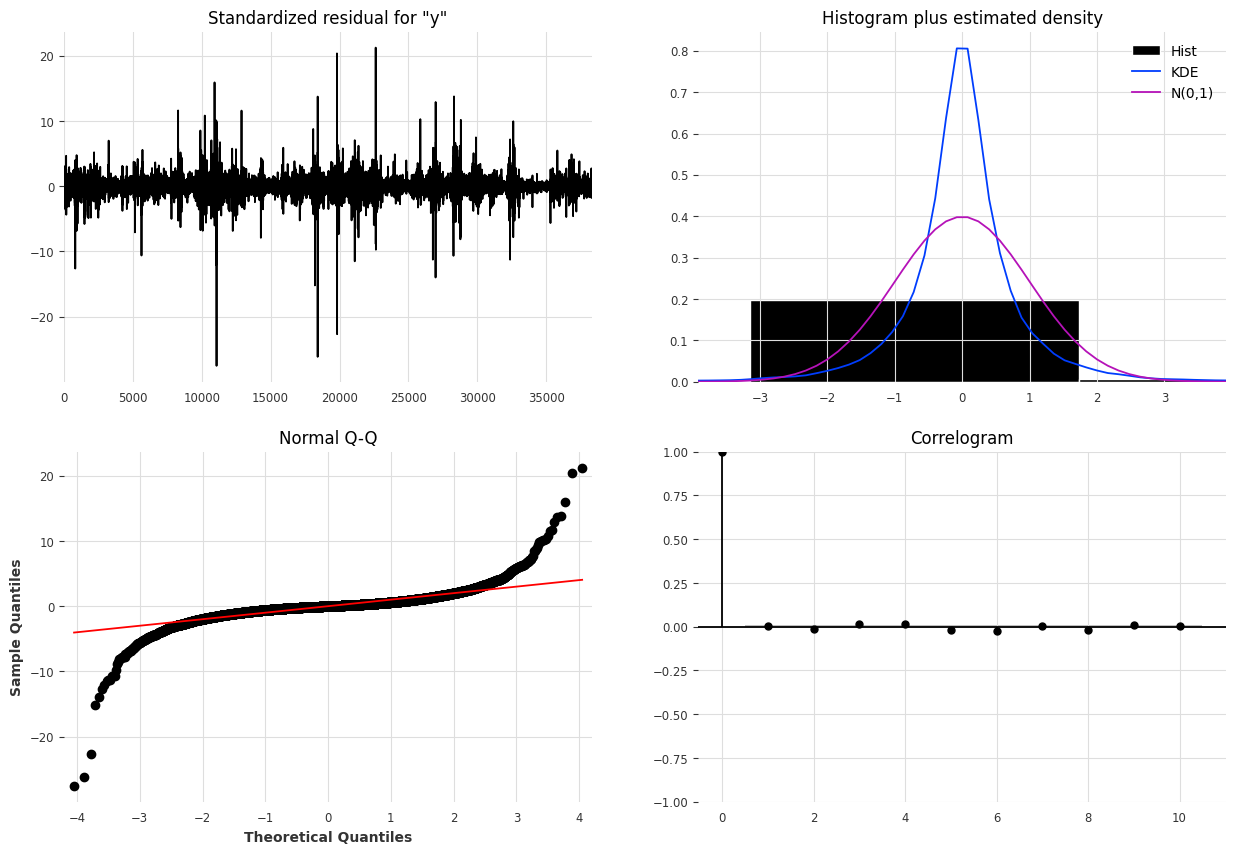

In [23]:
ar1.plot_diagnostics(figsize = (15, 10))
plt.show()

### 3.2.2 GARCH model for the residuals
To decide whether or not it would be interesting to fit a GARCH model on the residuals of the AR(1) model, the procedure consists in


*   first checking whether the residuals are a white noise (in case there is no need for a GARCH model). This can be done by conducting a Ljung-Box (LB) Test, which assumes the null hypothesis of white noise property.
*   second, if the residuals are indeed not a white noise, checking for the presence of ARCH effects. This can be done with the help of the Lagrange-Multiplier (LM) Test, which assumes the null hypothesis of absence of such effects.

On the diagnosis plots above, residuals of the chosen model are analysed. We do not see apparent trend (top left-hand corner) but the histograms and Q-Q plots (top right-hand and bottom left-hand corners) hint non-normality of residuals, which indicates that the model’s residuals still contains information.

In [24]:
white_noise = acorr_ljungbox(ar1.resid, lags = [10], return_df=True)
print("--- Ljung-Box Test ---")
print(f"Test statistics = {white_noise.iloc[0,0]}, p-value = {white_noise.iloc[0,1]}")
print('As p-value < 0.01, we can safely reject the white noise property of the residuals.')

--- Ljung-Box Test ---
Test statistics = 71.67708952745143, p-value = 2.10137512818617e-11
As p-value < 0.01, we can safely reject the white noise property of the residuals.


In [25]:
statistics, LM_pvalue = het_arch(ar1.resid, ddof = 4)[0:2]
print("--- Lagrange-Multiplier Test ---")
print(f"Test statistics = {statistics}, p-value = {LM_pvalue}")
print('As p-value < 0.01, we can safely reject absence of ARCh effects in the residuals.')

--- Lagrange-Multiplier Test ---
Test statistics = 1920.7412890001758, p-value = 0.0
As p-value < 0.01, we can safely reject absence of ARCh effects in the residuals.


As explained before, we conducted LJ and LM tests and the results encourage us to fit a GARCH model. As GARCH model is nothing more than an ARMA model on the squared residuals, we look at the ACF and PACF graphs.

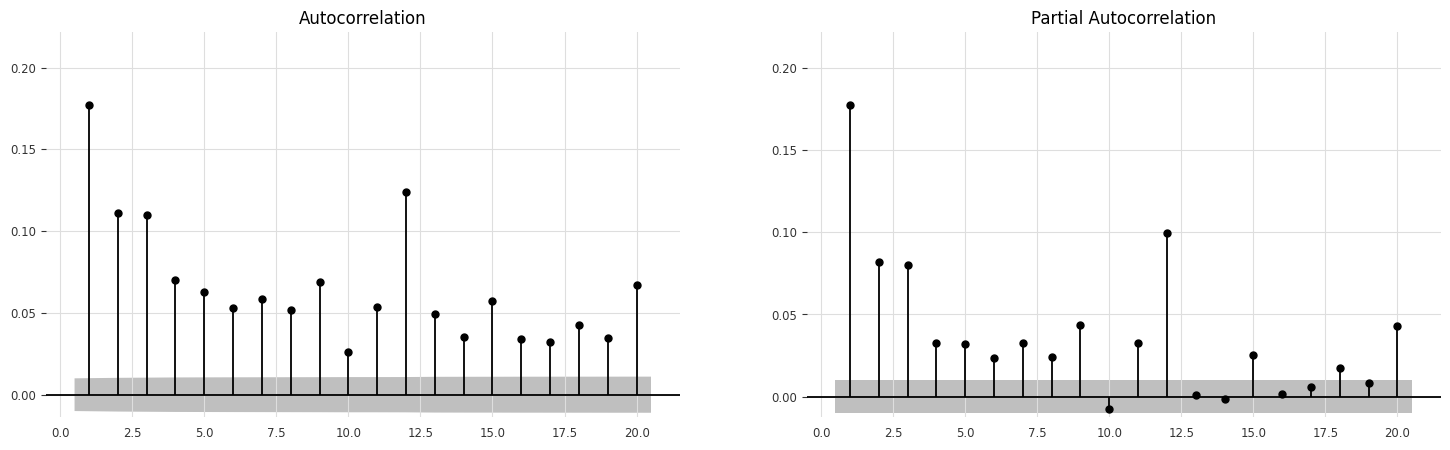

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (18,5))
squared_residuals = ar1.resid**2
sgt.plot_acf(squared_residuals, zero = False, lags = 20, ax=ax[0], alpha=0.05, auto_ylims=True, title='Autocorrelation')
sgt.plot_pacf(squared_residuals, zero = False, lags = 20, ax=ax[1], alpha=0.05, auto_ylims=True, title='Partial Autocorrelation')
plt.show()

It looks like we should test $p\leq 9$ and $q\leq 10$. In fact, the only models that are not ill-specified (i.e whose coefficients are all statistically significant) are those with $p\leq 1$ and $q\leq 2$. We chose $p=1$ and $q=2$ because it presented the lowest AIC and BIC (see cells below).

In [27]:
garch12 = arch_model(ar1.resid*100, vol = 'GARCH', p = 1, q = 2)
garch12 = garch12.fit()
garch12.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 272260.8844955372
Iteration:      2,   Func. Count:     14,   Neg. LLF: 277420.84412692086
Iteration:      3,   Func. Count:     22,   Neg. LLF: 192673.67569620165
Iteration:      4,   Func. Count:     29,   Neg. LLF: 265959.97231009736
Iteration:      5,   Func. Count:     36,   Neg. LLF: 192505.26702804456
Iteration:      6,   Func. Count:     43,   Neg. LLF: 192329.45149583687
Iteration:      7,   Func. Count:     50,   Neg. LLF: 192094.6003491053
Iteration:      8,   Func. Count:     57,   Neg. LLF: 191929.21233392
Iteration:      9,   Func. Count:     64,   Neg. LLF: 191896.08705236638
Iteration:     10,   Func. Count:     70,   Neg. LLF: 191895.75093180223
Iteration:     11,   Func. Count:     76,   Neg. LLF: 191895.70214540235
Iteration:     12,   Func. Count:     82,   Neg. LLF: 191895.771063524
Iteration:     13,   Func. Count:     89,   Neg. LLF: 191895.5967528441
Iteration:     14,   Func. Count:     94,   Neg. LLF: 19189

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -191896.
Distribution:                  Normal   AIC:                           383801.
Method:            Maximum Likelihood   BIC:                           383844.
                                        No. Observations:                38342
Date:                Fri, Jan 19 2024   Df Residuals:                    38341
Time:                        17:04:09   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0853      0.174      0.489      0.625 [ -0.256,  0.427]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         14.6885      4.314      3.405  6.622e-04   [  6.233, 23.144]
alpha[1]       0.1176  1.403e-02      8.378  5.371e-17 [9.008e-02,  0.145]
beta[1]        0.3810  7.782e-02      4.896  9.805e-07   [  0.228,  0.533]
beta[2]        0.5015  7.234e-02      6.932  4.156e-12   [  0.360,  0.643]
==========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

Here, we fitted the GARCH(1,2) model on `ar1.resid * 100` instead of `ar1.resid` to prevent any numerical issues.

### Performances

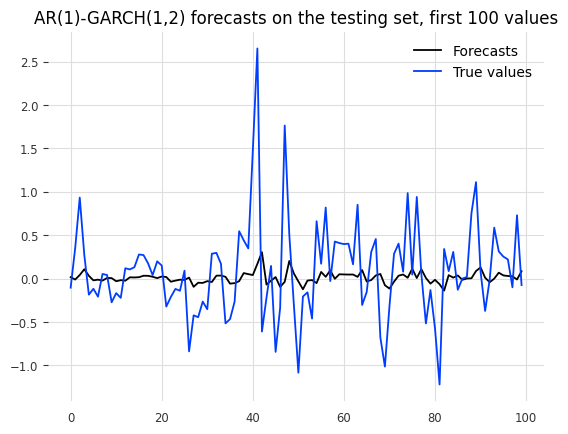

In [29]:
ar1_to_test = ar1.append(Y_test, refit=False)
predictions_on_test = ar1_to_test.predict()[Y_train.shape[0]:]

plt.plot(predictions_on_test[:100], label="Forecasts")
plt.plot(Y_test[:100], label = "True values")
plt.legend()
plt.title("AR(1)-GARCH(1,2) forecasts on the testing set, first 100 values")
plt.show()

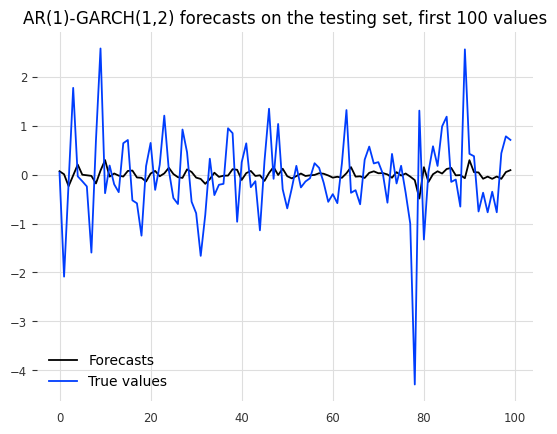

In [30]:
plt.plot(predictions_on_test[150:250], label="Forecasts")
plt.plot(Y_test[150:250], label = "True values")
plt.legend()
plt.title("AR(1)-GARCH(1,2) forecasts on the testing set, first 100 values")
plt.show()

In [34]:
print(np.corrcoef(predictions_on_test, Y_test.reshape(1, -1)[0]))

[[1.         0.17267932]
 [0.17267932 1.        ]]


In [33]:
RMSE = np.sqrt(((predictions_on_test - Y_test.reshape(1, -1)[0])**2).mean())
print(f'RMSE: {RMSE}')

RMSE: 0.41040323876195794


In [35]:
def forecast_log_return():
  """
  Returns the forecast value of Y_test[0]
  """
  # Use ARIMA to predict mu
  predicted_mu = ar1.forecast()[0]
  # Use GARCH to predict the residual
  predicted_epsilon_t = garch12.forecast().mean['h.1'].iloc[-1] / 100 # We divide by 100 to account for the previous *100
  # Combine both models' output: yt = mu + epsilon_t
  prediction_Y_ = predicted_mu + predicted_epsilon_t
  prediction_Y = prediction_Y_ / 1000 # Again, we divide by 1000 to account for the fact that Y_ = Y * 1000
  print(prediction_Y)
  return prediction_Y

Knowing $\tilde{Y}_t$ and $X_{t-1}$, we can compute $\tilde{X}_t$ knowing that:

$$\tilde{Y}_t = \log(\tilde{X}_t/X_{t-1}) \quad \Leftrightarrow\quad \tilde{X}_t = X_{t-1}\exp(\tilde{Y}_t)$$

In [36]:
X_train = X.all_values().reshape(1, -1)[0 , :Y_train.shape[0]]
preds = np.roll(X_train, 1) * np.exp(ar1.predict() / 1000)

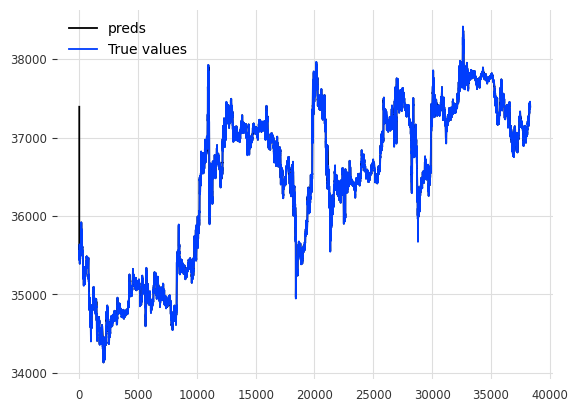

In [37]:
plt.plot(preds, label="preds")
plt.plot(X_train, label = "True values")
plt.legend()
plt.show()

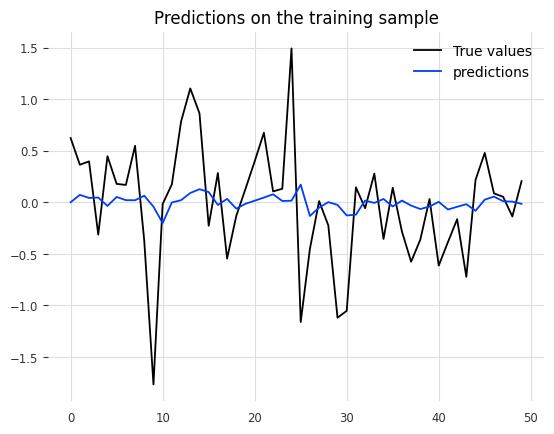

In [38]:
plt.plot(Y_train[:50], label = "True values")
plt.plot(ar1.predict()[:50], label = "predictions")
plt.legend()
plt.title("Predictions on the training sample")
plt.show()

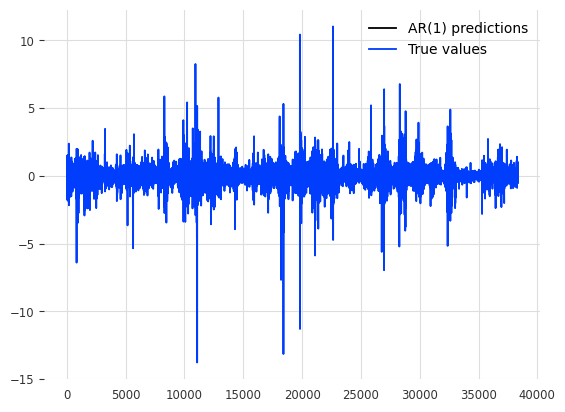

In [39]:
plt.plot(ar1.predict(), label="AR(1) predictions")
plt.plot(Y_train, label="True values")
plt.legend()
plt.show()

In the previous discussions, we were careful in ensuring that the assumptions under our modelization choices were backed by statistical tests. We can finally apply our model to a set of unseen data (the testing set). Figures above demonstrate that the model actually performs poorly. On the whole testing set ($4,261$ samples), the root mean squared error is $\simeq 0.4104$ and the observed correlation between the forecasts and the true values is $\simeq 0.1727$.

Indeed, this was expected as the Bitcoin is one of the most volatile asset on the market and the use of affine models could not capture its variability.

# Deep learning methods

Install these two packages if needed

In [ ]:
#pip install tensorflow
#pip install scikeras

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import joblib
import os
from tensorflow.keras.callbacks import ModelCheckpoint

## Data Selection using window sliding method

This section has to be run

In [ ]:
historical_data = historical_data.sort_values('Datetime')

X = np.asarray(historical_data[['Close']])
scaler = MinMaxScaler()

train_size = 0.8
test_size = 0.2

#The validation size is the proportion of the training dataset used for validation
val_share = 0.25

train = scaler.fit_transform(X[0:int(train_size*len(X)),:])
test = scaler.transform(X[int(train_size*len(X)):,:])

In [ ]:
# Function that creates a dataset matrix using window method
def create_dataset(dataset,delta=1) :
    """
    Inputs :
    --------
        dataset : array, datas matrix, the Y target must be in the last column
        delta : int, size of sequences in the sequences matrix
    Outputs :
    ---------
        dataX : array of the sequenced datas
        dataY : array of the target column Y
    """
    dataX,dataY = [],[]
    for i in range(len(dataset)-delta-1) :
        a = dataset[i:i+delta,:]
        dataX.append(a)
        dataY.append(dataset[i+delta,-1])
    return np.array(dataX),np.array(dataY)

In [ ]:
trainX,trainY = create_dataset(train,delta=5)
testX,testY = create_dataset(test,delta=5)

In [ ]:
trainY = trainY.reshape(len(trainY),1)
testY = testY.reshape(len(testY),1)

## How the model work using simple configuration

This section show the method used to build RNN architectures and predict future outcomes, it execution is not mandatory but don't take much time.

In [ ]:
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape = (5,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')
model.fit(x = trainX, y = trainY, epochs = 100,batch_size=64)

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

262/262 [==============================] - 1s 3ms/step


In [ ]:
blanktrainP = np.zeros((trainPredict.shape[0],4))
blanktrainP[:,3] = trainPredict[:,0]
blanktrainP = scaler.inverse_transform(blanktrainP)
trainPredict_inv = blanktrainP[:,3].reshape((len(trainPredict),1))

blanktrainY = np.zeros((trainY.shape[0],4))
blanktrainY[:,3] = trainY[:,0]
blanktrainY = scaler.inverse_transform(blanktrainY)
trainY_inv = blanktrainY[:,3].reshape((len(trainY),1))

blanktestP = np.zeros((testPredict.shape[0],4))
blanktestP[:,3] = testPredict[:,0]
blanktestP = scaler.inverse_transform(blanktestP)
testPredict_inv = blanktestP[:,3].reshape((len(testPredict),1))

blanktestY = np.zeros((testY.shape[0],4))
blanktestY[:,3] = testY[:,0]
blanktestY = scaler.inverse_transform(blanktestY)
testY_inv = blanktestY[:,3].reshape((len(testY),1))


In [ ]:
trainScore = np.sqrt(mean_squared_error(trainY_inv,trainPredict_inv))
testScore = np.sqrt(mean_squared_error(testY_inv,testPredict_inv))
print(trainScore,testScore)

19.40363031921503 14.884038457573922


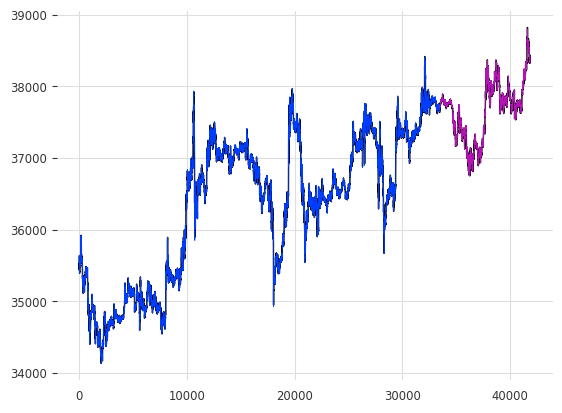

In [ ]:
trainPredictPlot = np.empty_like(X_scaled[:,0].reshape(len(X_scaled),1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[5:len(trainPredict_inv)+5,:] = trainPredict_inv

testPredictPlot = np.empty_like(X_scaled[:,0].reshape(len(X_scaled),1))
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict_inv)+(5*2)+1:len(X_scaled)-1,:] = testPredict_inv

plt.plot(scaler.inverse_transform(X_scaled),linewidth=1)
plt.plot(trainPredictPlot,linewidth = .5)
plt.plot(testPredictPlot,linewidth = .5)
plt.show()

## Model Generators
This section has to be run

Functions that create RNNs based on gridsearch parameters.

In [ ]:
def create_rnn_model(drop,depth,units, **kwargs):
    model = Sequential()
    model.add(SimpleRNN(units=units, input_shape=(trainX.shape[1], 1), return_sequences=True,dropout=drop))
    for k in range(depth-2) :
        model.add(SimpleRNN(units=units,return_sequences=True,dropout=drop))
    model.add(SimpleRNN(units=units,return_sequences=False,dropout=drop))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_lstm_model(drop,depth,units, **kwargs):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(trainX.shape[1], 1),return_sequences=True,dropout=drop))
    for k in range(depth-2) :
        model.add(LSTM(units=units,return_sequences=True,dropout=drop))
    model.add(LSTM(units=units,return_sequences=False,dropout=drop))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(drop,depth,units, **kwargs):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(trainX.shape[1], 1),return_sequences = True,dropout=drop))
    for k in range(depth-2) :
        model.add(GRU(units=units, return_sequences=True,dropout=drop))
    model.add(GRU(units=units, return_sequences=False,dropout=drop))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## GridSearch on Network Parameters
This section show how the hyperparameters search is proceeded. It is not supposed to be run

In [ ]:
#Since only the validation dataset is used to compare the models, we create a custom single fold splitter
n_val = int(trainX.shape[0]*val_share)

ps = PredefinedSplit((trainX.shape[0]-n_val)*[-1]+n_val*[0])

The next cell' execution time is very long and it is not supposed to be run again if the models have already been trained and saved

In [ ]:
rnn_model = KerasRegressor(build_fn=create_rnn_model, epochs=100, batch_size=64)
lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=64)
gru_model = KerasRegressor(build_fn=create_gru_model, epochs=100, batch_size=64)

param_grid_rnn = {
    'model__units': [32, 64],
    'model__depth' : [2,3,4,5],
    'model__drop' : [0,0.3]
}

param_grid_lstm = {
    'model__units': [32, 64],
    'model__depth' : [2,3,4,5],
    'model__drop' : [0,0.3]
}

param_grid_gru = {
    'model__units': [32, 64],
    'model__depth' : [2,3,4,5],
    'model__drop' : [0,0.3]
}

scoring = make_scorer(mean_squared_error, greater_is_better=False)

grid_rnn = GridSearchCV(estimator=rnn_model, param_grid=param_grid_rnn, scoring=scoring, cv=ps)
grid_lstm = GridSearchCV(estimator=lstm_model, param_grid=param_grid_lstm, scoring=scoring, cv=ps)
grid_gru = GridSearchCV(estimator=gru_model, param_grid=param_grid_gru, scoring=scoring, cv=ps)

grid_rnn_result = grid_rnn.fit(trainX, trainY)
grid_lstm_result = grid_lstm.fit(trainX, trainY)
grid_gru_result = grid_gru.fit(trainX, trainY)

In [ ]:
print("Best parameters for RNN: %s" % grid_rnn_result.best_params_)
print("Best parameters for LSTM: %s" % grid_lstm_result.best_params_)
print("Best parameters for GRU: %s"% grid_gru_result.best_params_)

Best parameters for RNN: {'model__depth': 5, 'model__drop': 0, 'model__units': 32}
Best parameters for LSTM: {'model__depth': 3, 'model__drop': 0, 'model__units': 32}
Best parameters for GRU: {'model__depth': 2, 'model__drop': 0, 'model__units': 64}


In [ ]:
print(grid_rnn_result.best_score_)
print(grid_lstm_result.best_score_)
print(grid_gru_result.best_score_)

-1.9337434921956368e-05
-1.8397964456854603e-05
-1.7298746224794975e-05


In [ ]:
trainX_noval = trainX[:trainX.shape[0]-n_val,:,:]
trainY_noval = trainY[:trainY.shape[0]-n_val,:]
valX = trainX[-n_val:,:,:]
valY = trainY[-n_val:,:]

The parameters used in the next cell are the ones selected in the Cross Validation.

In [ ]:
best_rnn_model = create_rnn_model(drop=0,depth=5,units=32)
best_lstm_model = create_lstm_model(drop=0,depth=3,units=32)
best_gru_model = create_gru_model(drop=0,depth=2,units=64)

checkpoint_path_rnn = "training_rnn/cp.ckpt"
checkpoint_path_lstm = "training_lstm/cp.ckpt"
checkpoint_path_gru = "training_gru/cp.ckpt"

checkpoint_dir_rnn = os.path.dirname(checkpoint_path_rnn)
checkpoint_dir_lstm = os.path.dirname(checkpoint_path_lstm)
checkpoint_dir_gru = os.path.dirname(checkpoint_path_gru)


cp_callback_rnn = ModelCheckpoint(filepath=checkpoint_path_rnn,save_weights_only=True,verbose=1)
cp_callback_lstm = ModelCheckpoint(filepath=checkpoint_path_lstm,save_weights_only=True,verbose=1)
cp_callback_gru = ModelCheckpoint(filepath=checkpoint_path_gru,save_weights_only=True,verbose=1)

In [ ]:
best_rnn_model.fit(trainX_noval, trainY_noval, epochs=100, batch_size=64, callbacks=[cp_callback_rnn])
best_lstm_model.fit(trainX_noval, trainY_noval, epochs=100, batch_size=64, callbacks=[cp_callback_lstm])
best_gru_model.fit(trainX_noval, trainY_noval, epochs=100, batch_size=64, callbacks=[cp_callback_gru])

## Loading models when already trained
Be sure the cells in the "Model Generators" section have all been executed before

In [ ]:
best_rnn_model = create_rnn_model(drop=0,depth=5,units=32)
best_lstm_model = create_lstm_model(drop=0,depth=3,units=32)
best_gru_model = create_gru_model(drop=0,depth=2,units=64)

checkpoint_path_rnn = "training_rnn/cp.ckpt"
checkpoint_path_lstm = "training_lstm/cp.ckpt"
checkpoint_path_gru = "training_gru/cp.ckpt"

best_rnn_model.load_weights(checkpoint_path_rnn)
best_lstm_model.load_weights(checkpoint_path_lstm)
best_gru_model.load_weights(checkpoint_path_gru)

In [ ]:
n_val = int(trainX.shape[0]*val_share)

trainX_noval = trainX[:trainX.shape[0]-n_val,:,:]
trainY_noval = trainY[:trainY.shape[0]-n_val,:]
valX =  trainX[-n_val:,:,:]
valY = trainY[-n_val:,:]

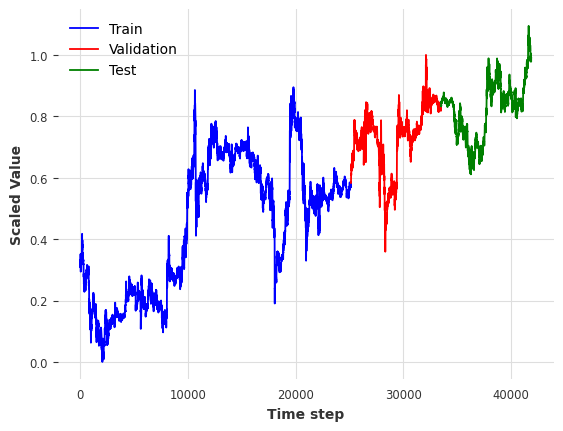

In [ ]:
plt.plot(np.arange(0,len(trainY_noval)),trainY_noval,color = 'blue',label = 'Train')
plt.plot(np.arange(len(trainY_noval),len(trainY)),valY,color = 'red',label = 'Validation')
plt.plot(np.arange(len(trainY),len(testY)+len(trainY)),testY,color = 'green',label = 'Test')
plt.ylabel('Scaled Value')
plt.xlabel('Time step')
plt.legend()

In [ ]:
train_rmse = []
val_rmse = []
test_rmse = []
for mod in [best_rnn_model,best_lstm_model,best_gru_model] :
    train_r = mod.evaluate(trainX_noval,trainY_noval,verbose=0)
    val_r = mod.evaluate(valX,valY,verbose=0)
    test_r = mod.evaluate(testX,testY,verbose=0)
    train_rmse.append(np.sqrt(train_r))
    val_rmse.append(np.sqrt(val_r))
    test_rmse.append(np.sqrt(test_r))

In [ ]:
print('Best RNN rmse on :\n Train : ' + str(train_rmse[0])+'\n' + ' Validation : ' + str(val_rmse[0])+'\n' + ' Test : ' + str(test_rmse[0]))
print('Best LSTM rmse on :\n Train : ' + str(train_rmse[1])+'\n' + ' Validation : ' + str(val_rmse[1])+'\n' + ' Test : ' + str(test_rmse[1]))
print('Best GRU rmse on :\n Train : ' + str(train_rmse[2])+'\n' + ' Validation : ' + str(val_rmse[2])+'\n' + ' Test : ' + str(test_rmse[2]))

Best RNN rmse on :
 Train : 0.004651181980518282
 Validation : 0.005289273786299701
 Test : 0.007159982768807393
Best LSTM rmse on :
 Train : 0.005002858752839223
 Validation : 0.005289733562676126
 Test : 0.004116875608904496
Best GRU rmse on :
 Train : 0.00442634144352181
 Validation : 0.0045378313320997895
 Test : 0.00336800032583114


In [ ]:
non_scaled_train_rmse = (scaler.data_max_ - scaler.data_min_)*train_rmse
non_scaled_val_rmse = (scaler.data_max_ - scaler.data_min_)*val_rmse
non_scaled_test_rmse = (scaler.data_max_ - scaler.data_min_)*test_rmse

print('Best RNN non scaled rmse on :\n Train : ' + str(non_scaled_train_rmse[0])+'\n' + ' Validation : ' + str(non_scaled_val_rmse[0])+'\n' + ' Test : ' + str(non_scaled_test_rmse[0]))
print('Best LSTM non scaled rmse on :\n Train : ' + str(non_scaled_train_rmse[1])+'\n' + ' Validation : ' + str(non_scaled_val_rmse[1])+'\n' + ' Test : ' + str(non_scaled_test_rmse[1]))
print('Best GRU non scaled rmse on :\n Train : ' + str(non_scaled_train_rmse[2])+'\n' + ' Validation : ' + str(non_scaled_val_rmse[2])+'\n' + ' Test : ' + str(non_scaled_test_rmse[2]))

Best RNN non scaled rmse on :
 Train : 19.915888854909387
 Validation : 22.6481331610664
 Test : 30.6583190302833
Best LSTM non scaled rmse on :
 Train : 21.421733076815467
 Validation : 22.65010187681421
 Test : 17.628043237150024
Best GRU non scaled rmse on :
 Train : 18.95314451085753
 Validation : 19.43053289055663
 Test : 14.42143533267585


In [ ]:
true_var = testY[1:]-testY[:-1]
pred_var = best_gru_model.predict(testX,verbose =0)[1:] - testY[:-1]

In [ ]:
print('Proportion of time the right variation is predicted : ' + str(round(np.mean(np.sign(true_var) == np.sign(pred_var)),2)))

Proportion of time the right variation is predicted : 0.53


In [ ]:
rnn_pred = best_rnn_model.predict(testX,verbose=0)
lstm_pred = best_lstm_model.predict(testX,verbose=0)
gru_pred = best_gru_model.predict(testX,verbose=0)

(40000.0, 42000.0, 0.75, 1.1)

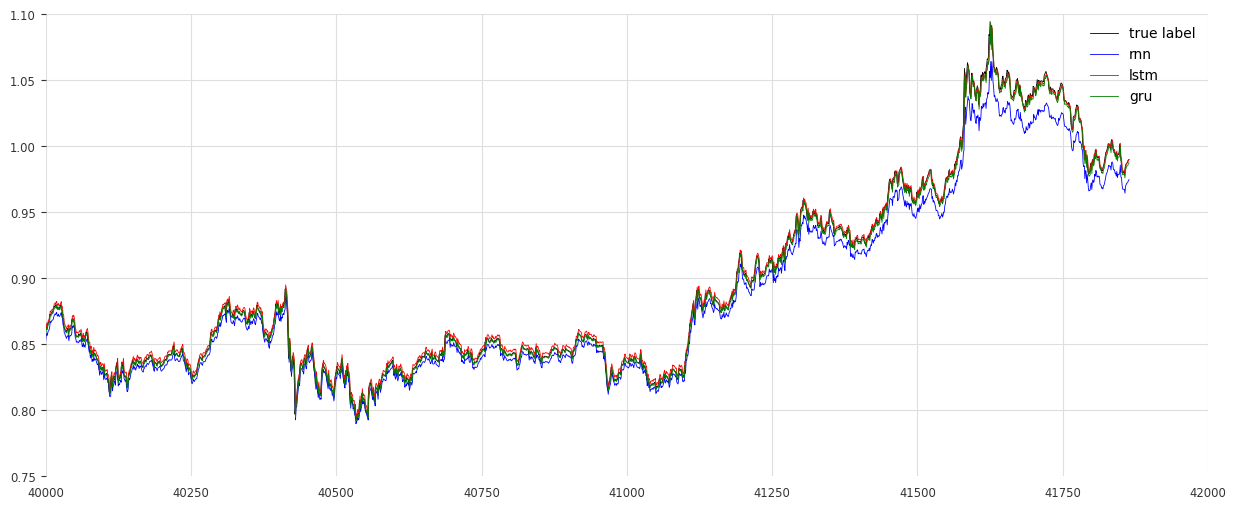

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.plot(np.arange(len(train),len(train)+len(testY)),testY,color = 'black',label = 'true label',linewidth = 0.6)
plt.plot(np.arange(len(train),len(train)+len(testY)),rnn_pred,color='blue',label = 'rnn',linewidth = 0.6)
plt.plot(np.arange(len(train),len(train)+len(testY)),lstm_pred,color='red',label = 'lstm',linewidth = 0.6)
plt.plot(np.arange(len(train),len(train)+len(testY)),gru_pred,color='green',label = 'gru',linewidth = 0.6)
plt.legend()
plt.axis([40000,42000,0.75,1.1])